Github repo here: https://github.com/tehqua/LongNetTSA-ParisTemperature/tree/main

Key Features of LongNet
* Dilated Attention: Instead of attending to all tokens simultaneously, LongNet uses a hierarchical dilation pattern. For example, it might first attend to nearby tokens, then skip progressively larger gaps, capturing both local and global dependencies efficiently.
* Scalability: It scales sequence length without a proportional increase in memory or computation, breaking the barrier of previous transformer limits (e.g., 4,096 tokens in GPT-3 or 32,768 in some optimized models).
* Preserved Expressivity: Unlike some sparse attention methods (e.g., Linformer or Performer) that sacrifice some modeling power for efficiency, LongNet aims to retain the transformer’s ability to capture complex relationships.

LongNet and Time Series Forecasting
While LongNet was developed with NLP in mind, its ability to handle long sequences makes it potentially relevant to time series forecasting, especially for long sequence time-series forecasting (LSTF). In time series, capturing dependencies across thousands or millions of time steps (e.g., high-frequency sensor data, financial ticks, or climate records) is a challenge. Traditional models like LSTMs struggle with vanishing gradients over long horizons, and even transformer variants like Informer or Autoformer are typically tested on sequences of a few hundred to a few thousand steps.

LongNet’s billion-token capacity could theoretically process years of hourly or minute-level data in one go (e.g., 1 year of minute data = 525,600 points), far exceeding the scope of most current time series models. However, as of April 7, 2025, there’s no widely documented application of LongNet specifically to time series forecasting in the public domain. Its adoption in this field would require adaptation, such as:
* Modifying the attention mechanism to prioritize temporal locality (nearby time steps often matter more in time series).
* Handling multivariate inputs, which are common in time series but differ from the token-based inputs of NLP.
* Integrating time-specific features (e.g., seasonality, trends) that aren’t inherent in text data.

Some recent transformer-based time series models (e.g., PatchTST, iTransformer) have explored patching or inverting attention to manage long sequences, but none reach LongNet’s scale. LongNet’s dilation approach could inspire future LSTF models, especially for domains like energy forecasting or climate modeling where ultra-long histories are valuable.

Current Status and Availability:
There’s no standard open-source implementation widely adopted (like Hugging Face’s transformers library), but the concept has sparked interest in scaling transformers further. Posts on X from 2023 highlight excitement about its potential, though practical deployments remain limited or experimental.

# 0. Import Libraries and Read Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
from sklearn.impute import KNNImputer

In [ ]:
df = pd.read_csv("/kaggle/input/parislongnet/merged_paris_temperature.csv")

In [ ]:
# Sort theo datetime tu 2014 - 2024
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by='datetime')

# 1. Data Checking

## 1.1. Crawling Check

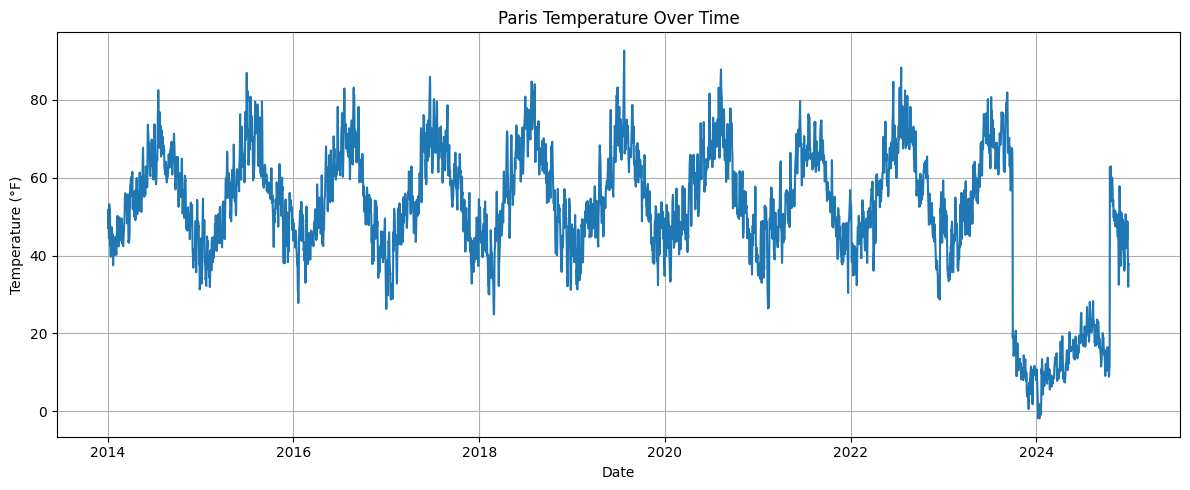

In [ ]:
# Convert datetime column to pandas datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Set datetime as the index
df.set_index('datetime', inplace=True)

# Plot the temperature column
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['temp'])
plt.title("Paris Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°F)")
plt.grid(True)
plt.tight_layout()
plt.show()


There is a discrepancy between units C and F when crawling data, and it needs to be converted back.  
=> Convert from C to F within the time range from 2023-10-01 to 2024-10-16.

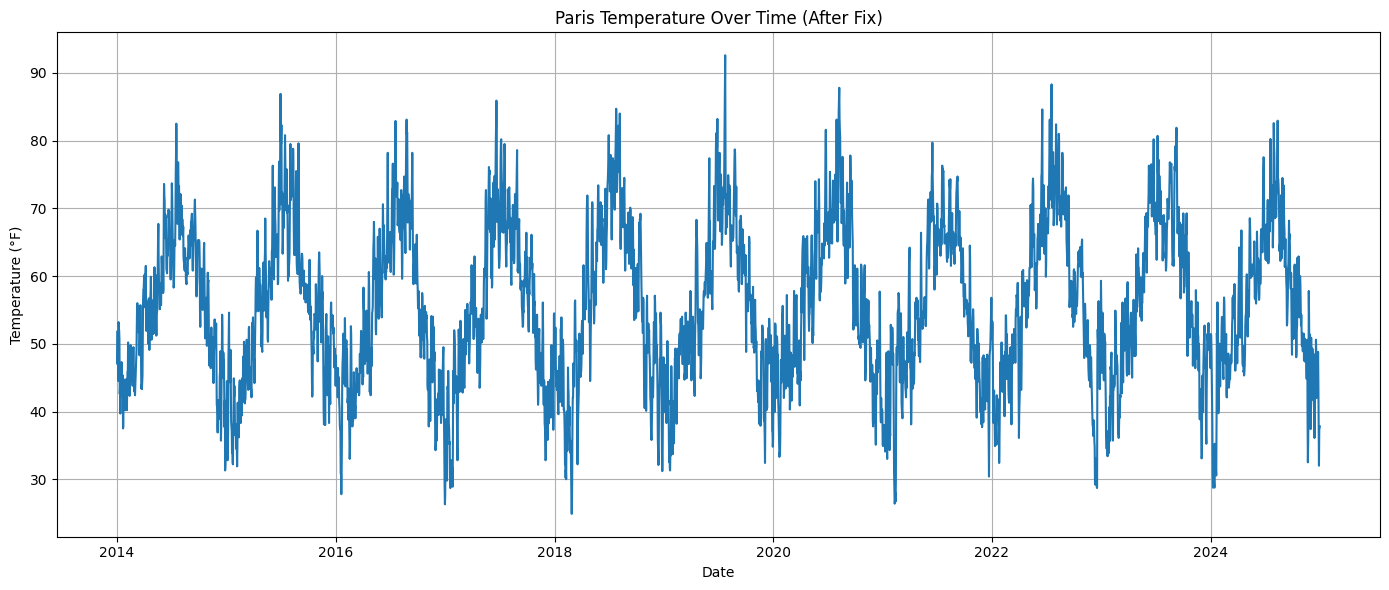

In [ ]:
# Convert from C to F within the time range from 2023-10-01 to 2024-10-16.
columns_to_convert = ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike']
start_date = pd.to_datetime("2023-10-01")
end_date = pd.to_datetime("2024-10-16")
mask = (df.index >= start_date) & (df.index <= end_date)

# F = (C × 9/5) + 32
df.loc[mask, columns_to_convert] = df.loc[mask, columns_to_convert] * 9/5 + 32

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['temp'])
plt.title("Paris Temperature Over Time (After Fix)")
plt.xlabel("Date")
plt.ylabel("Temperature (°F)")
plt.grid(True)
plt.tight_layout()
plt.show()


## 1.2. Stationarity Check

Actually, we do not need to check the stationarity. Unlike traditional statistical models like ARIMA, which are built on strong mathematical assumptions (e.g., stationarity, linearity), deep learning models like LongNet, LSTM, or Transformers are data-driven:
- They do not assume stationarity.
- They can learn non-linear trends, seasonality, and shifts directly from raw time series.
- They often perform better with minimal pre-processing.

However, checking stationarity can still help me:
- Understand the structure of your data.
- Decide whether to normalize, detrend, or use residuals for training.
- Improve convergence or training stability in some architectures.

So I believe that this step is not an importance step, but it will help me to understand my dataset

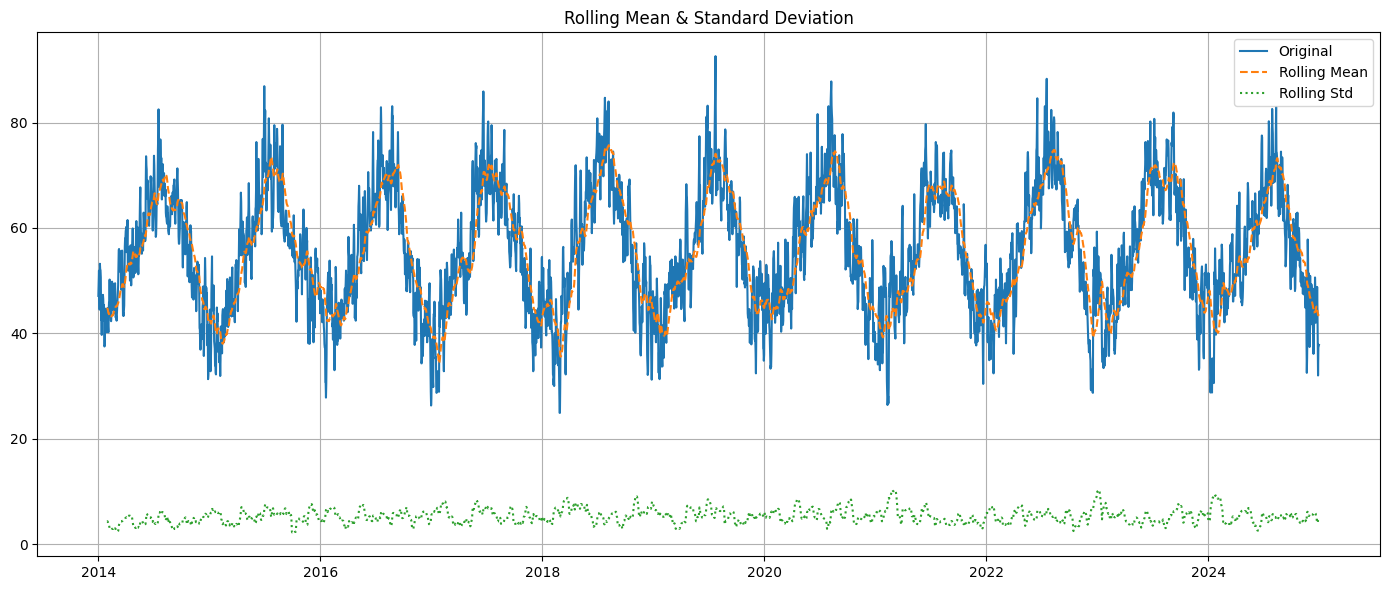

{'Test Statistic': -3.9736634063264002,
 'p-value': 0.001554872695866928,
 '#Lags Used': 18,
 'Number of Observations Used': 3999,
 'Critical Value (1%)': -3.431986284700283,
 'Critical Value (5%)': -2.862263021072379,
 'Critical Value (10%)': -2.5671548718243575}

In [ ]:
# Step 1: Visual inspection
rolling_mean = df['temp'].rolling(window=30).mean()
rolling_std = df['temp'].rolling(window=30).std()

plt.figure(figsize=(14, 6))
plt.plot(df['temp'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean', linestyle='--')
plt.plot(rolling_std, label='Rolling Std', linestyle=':')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 2: ADF test function
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        '#Lags Used': result[2],
        'Number of Observations Used': result[3]
    }
    for key, value in result[4].items():
        output[f'Critical Value ({key})'] = value
    return output

# ADF test on original data
adf_result_original = adf_test(df['temp'])
adf_result_original


The time series is stationary.
Strong evidence that low p-value and test statistic is lower than all critical values.

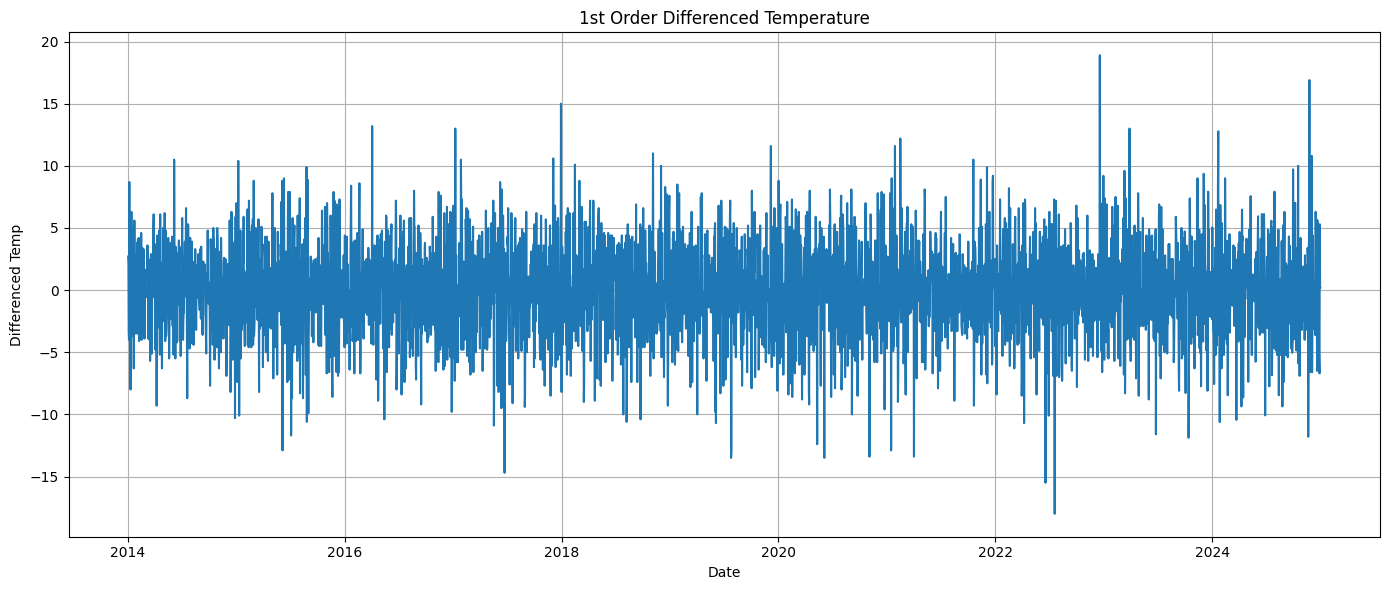

{'Test Statistic': -19.463804866044494,
 'p-value': 0.0,
 '#Lags Used': 21,
 'Number of Observations Used': 3995,
 'Critical Value (1%)': -3.431987924087406,
 'Critical Value (5%)': -2.862263745264969,
 'Critical Value (10%)': -2.56715525735392}

In [ ]:
# Step 3: First-order differencing
df_diff1 = df['temp'].diff()

# ADF test after first differencing
adf_result_diff1 = adf_test(df_diff1)

# Plot the differenced data
plt.figure(figsize=(14, 6))
plt.plot(df_diff1, label='1st Order Differenced Temp')
plt.title('1st Order Differenced Temperature')
plt.xlabel('Date')
plt.ylabel('Differenced Temp')
plt.grid(True)
plt.tight_layout()
plt.show()

# Return test result
adf_result_diff1


# 2. EDA

## 2.1. Functions

In [ ]:
from phik import phik_matrix
from phik.report import plot_correlation_matrix
# Hiển thị đồ họa đẹp hơn
sns.set(style="whitegrid")
# 1. Kiểm tra bản ghi trùng lặp
def check_duplicates(df):
    duplicates = df.duplicated().sum()
    print(f" Số bản ghi trùng lặp: {duplicates}")
# 2. Missing values và biểu đồ
def missing_values_info(df):
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    if missing.empty:
        print(" Không có missing values.")
    else:
        print(" Các cột có missing values:\n", missing)

        # Biểu đồ minh họa
        plt.figure(figsize=(10, 5))
        sns.barplot(x=missing.index, y=missing.values)
        plt.title("Missing Values per Column")
        plt.ylabel("Số lượng Missing")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
# 3. Phân loại cột
def get_column_types(df):
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    print(" Numerical columns:", numerical_cols)
    print(" Categorical columns:", categorical_cols)
    return numerical_cols, categorical_cols
# 4. Kiểm tra correlation giữa các numerical columns
def numerical_correlation(df, numerical_cols):
    corr = df[numerical_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Heatmap Correlation giữa các Numerical Columns")
    plt.show()
# 5. Kiểm tra Outlier bằng boxplot
def detect_outliers(df, numerical_cols):
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]

        print(f" {col}: {len(outliers)} outliers")

        # Boxplot
        plt.figure(figsize=(6, 3))
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot for {col}")
        plt.tight_layout()
        plt.show()
# 6. Phik matrix cho các categorical columns
def categorical_phik_matrix(df, categorical_cols):
    df_cat = df[categorical_cols].fillna('Missing')
    phik_mat = df_cat.phik_matrix(interval_cols=[])
    plot_correlation_matrix(phik_mat.values, x_labels=phik_mat.columns, y_labels=phik_mat.index,
                            vmin=0, vmax=1, color_map="Blues", figsize=(10, 8))
    plt.title("Phik Correlation Matrix (Categorical)")
    plt.show()

# 7. Frequency count + barplot cho categorical columns
def plot_categorical_distributions(df, categorical_cols):
    for col in categorical_cols:
        counts = df[col].value_counts()
        print(f"\n Frequency của cột {col}:\n", counts)

        plt.figure(figsize=(8, 4))
        sns.barplot(x=counts.index, y=counts.values)
        plt.title(f"Distribution of {col}")
        plt.ylabel("Tần suất")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

## 2.2.Exploratory Data Analysis

In [ ]:
# Kiểm tra trùng lặp
check_duplicates(df)

🔁 Số bản ghi trùng lặp: 0


 Các cột có missing values:
 severerisk    3636
preciptype    1748
stations        14
dtype: int64


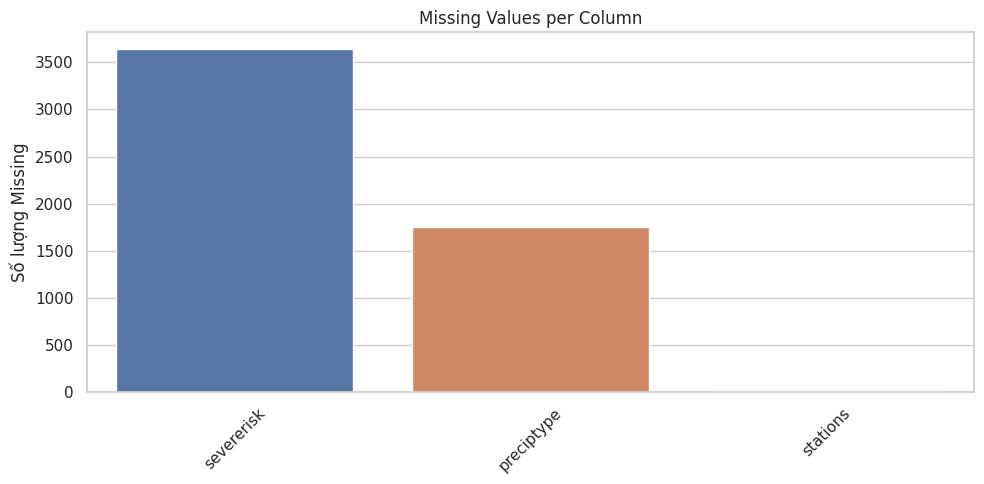

In [ ]:
# Kiểm tra missing values
missing_values_info(df)

In [ ]:
# Lấy danh sách numerical và categorical columns
numerical_cols, categorical_cols = get_column_types(df)

 Numerical columns: ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase']
 Categorical columns: ['name', 'preciptype', 'sunrise', 'sunset', 'conditions', 'description', 'icon', 'stations']


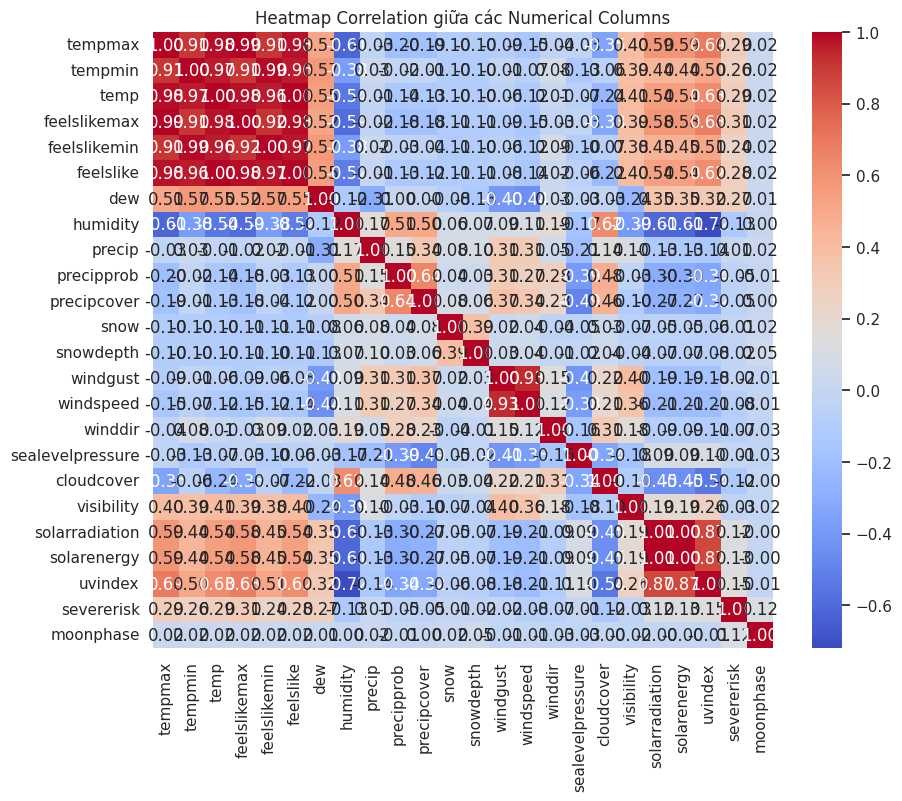

In [ ]:
numerical_correlation(df, numerical_cols)

 tempmax: 2 outliers


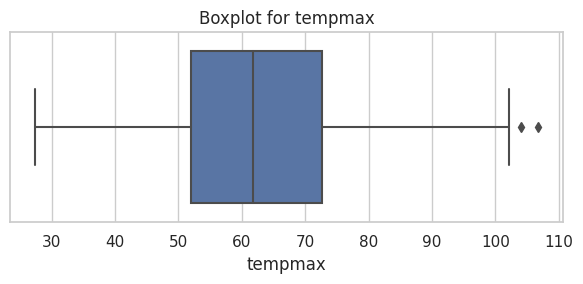

 tempmin: 0 outliers


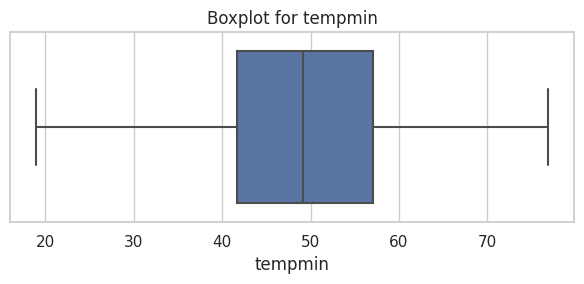

 temp: 1 outliers


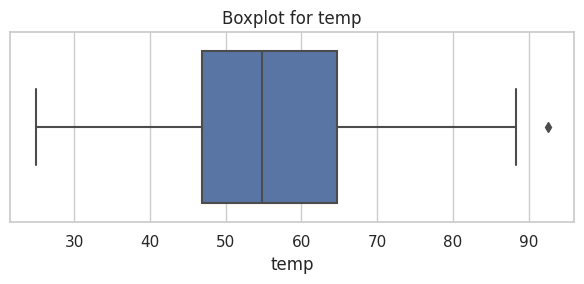

 feelslikemax: 3 outliers


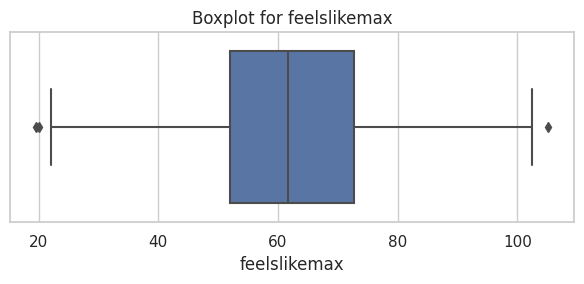

 feelslikemin: 1 outliers


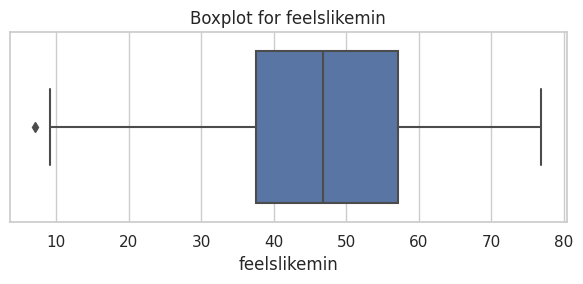

 feelslike: 0 outliers


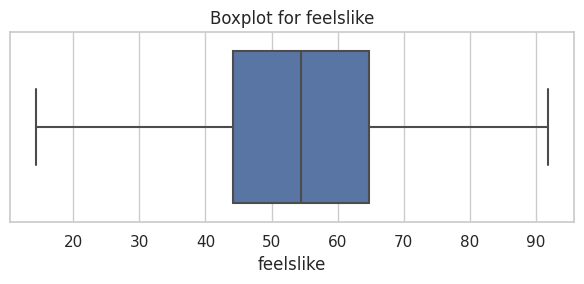

 dew: 303 outliers


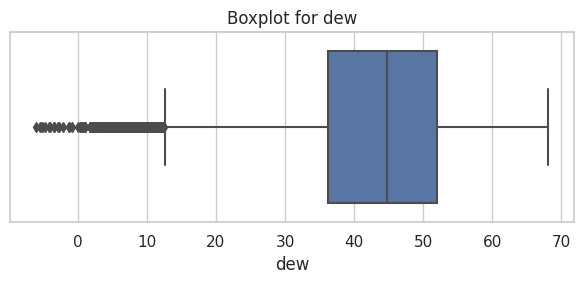

 humidity: 3 outliers


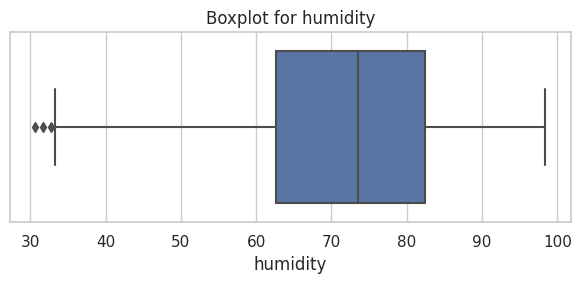

 precip: 632 outliers


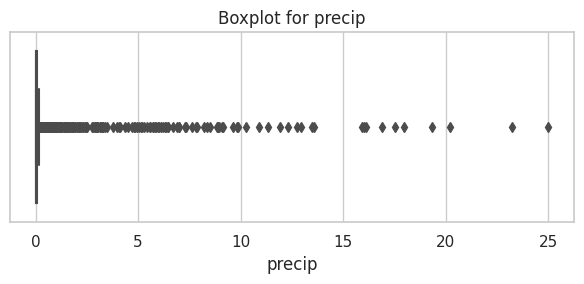

 precipprob: 0 outliers


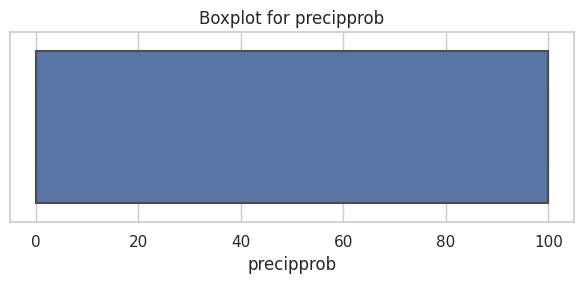

 precipcover: 197 outliers


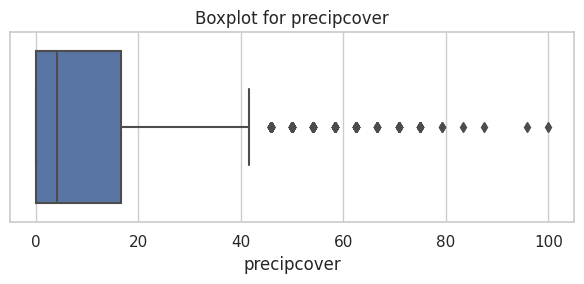

 snow: 33 outliers


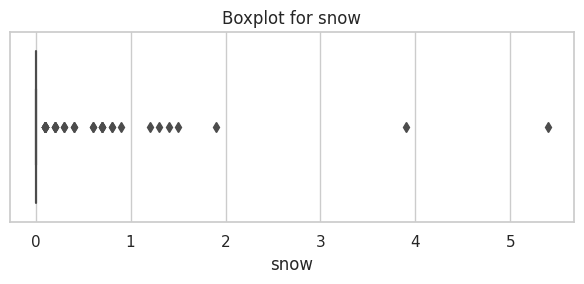

 snowdepth: 70 outliers


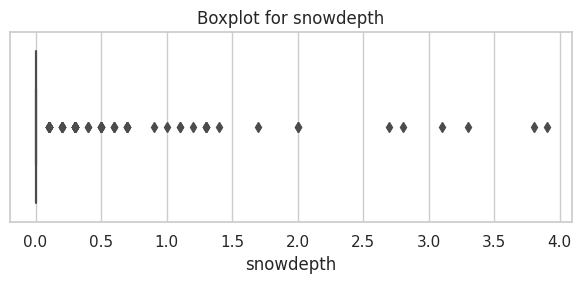

 windgust: 152 outliers


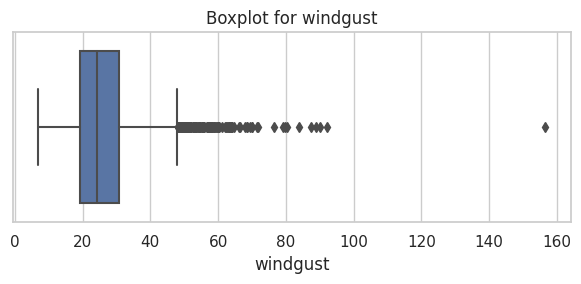

 windspeed: 130 outliers


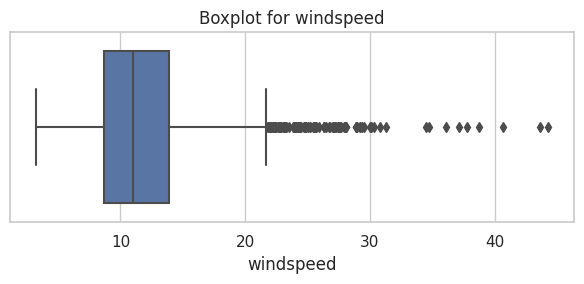

 winddir: 0 outliers


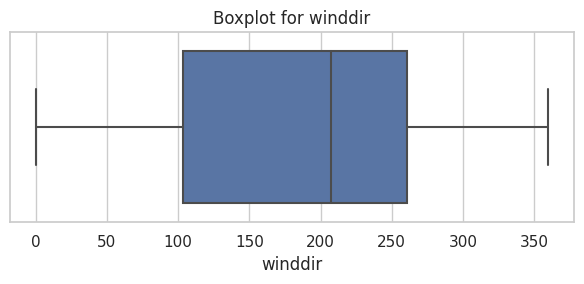

 sealevelpressure: 109 outliers


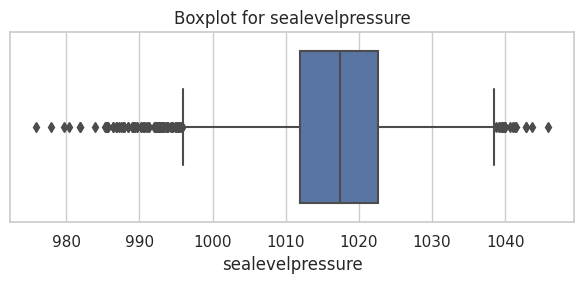

 cloudcover: 49 outliers


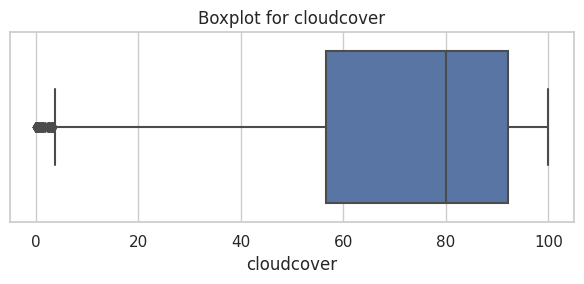

 visibility: 270 outliers


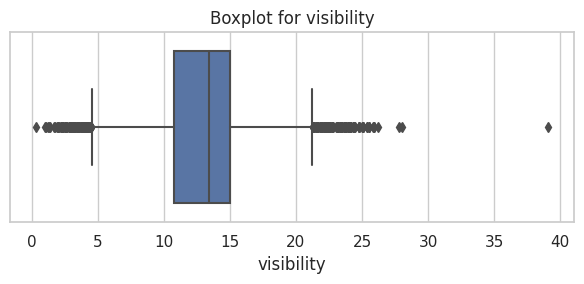

 solarradiation: 85 outliers


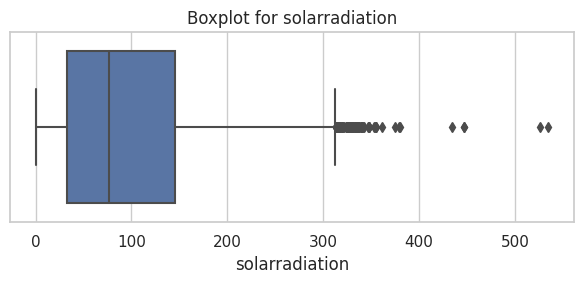

 solarenergy: 84 outliers


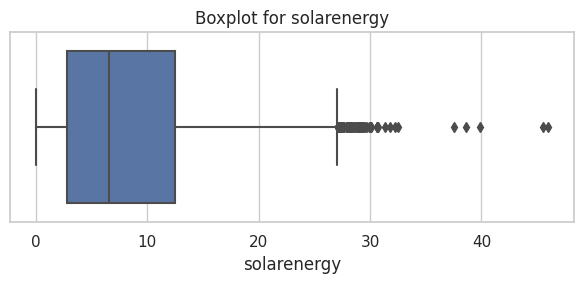

 uvindex: 0 outliers


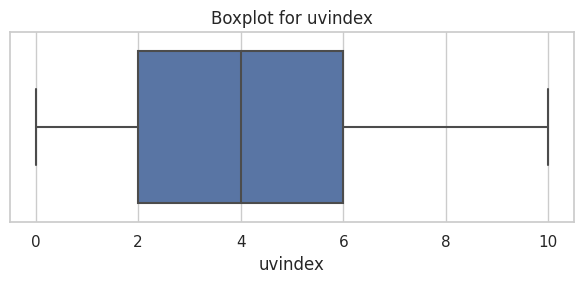

 severerisk: 9 outliers


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


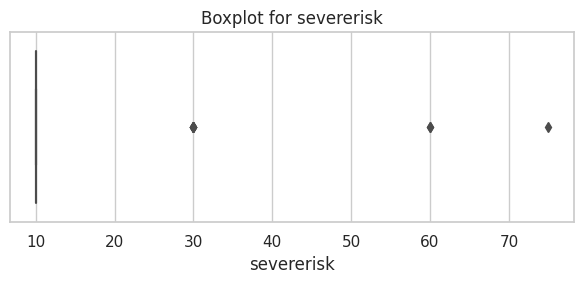

 moonphase: 0 outliers


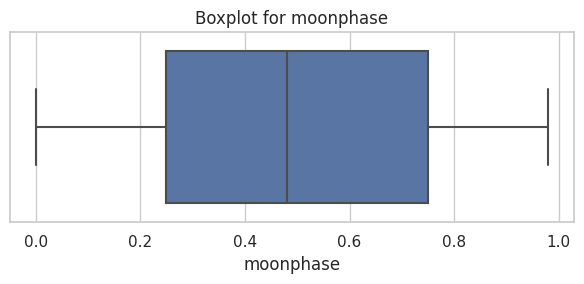

In [ ]:
detect_outliers(df, numerical_cols)


 Frequency của cột name:
 name
Paris, Île-de-France, France    3636
Paris,France                     382
Name: count, dtype: int64


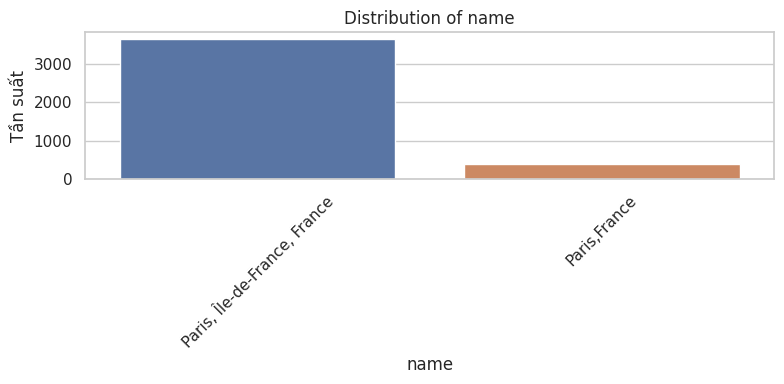


 Frequency của cột preciptype:
 preciptype
rain                      2197
rain,snow                   71
snow                         1
rain,freezingrain,snow       1
Name: count, dtype: int64


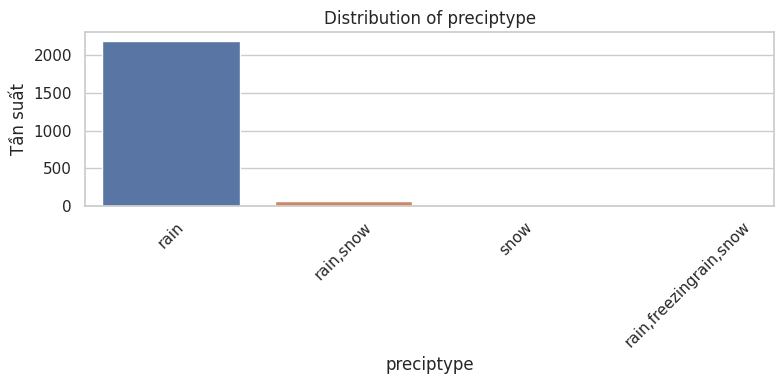


 Frequency của cột sunrise:
 sunrise
2014-01-01 08:44:10    1
2021-05-07 06:20:18    1
2021-04-24 06:42:25    1
2021-04-25 06:40:35    1
2021-04-26 06:38:47    1
                      ..
2017-09-06 07:14:26    1
2017-09-07 07:15:51    1
2017-09-08 07:17:16    1
2017-09-09 07:18:41    1
2024-12-31 08:44:14    1
Name: count, Length: 4018, dtype: int64


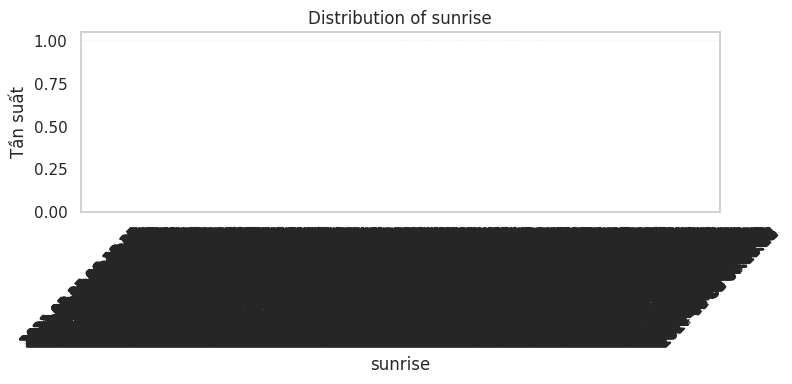


 Frequency của cột sunset:
 sunset
2014-01-01 17:04:22    1
2021-05-07 21:15:01    1
2021-04-24 20:56:05    1
2021-04-25 20:57:33    1
2021-04-26 20:59:02    1
                      ..
2017-09-06 20:22:28    1
2017-09-07 20:20:22    1
2017-09-08 20:18:16    1
2017-09-09 20:16:10    1
2024-12-31 17:03:44    1
Name: count, Length: 4018, dtype: int64


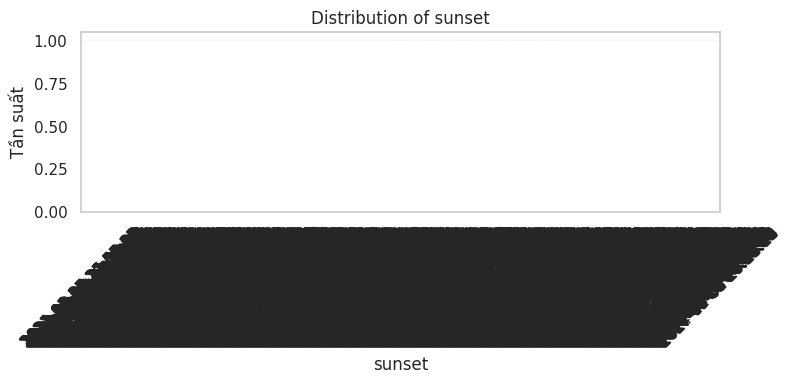


 Frequency của cột conditions:
 conditions
Partially cloudy                                                1287
Rain, Partially cloudy                                          1202
Rain, Overcast                                                   942
Overcast                                                         251
Clear                                                            247
Snow, Rain, Partially cloudy                                      36
Snow, Rain, Overcast                                              32
Rain                                                              19
Snow, Overcast                                                     1
Snow, Rain, Freezing Drizzle/Freezing Rain, Partially cloudy       1
Name: count, dtype: int64


<ipython-input-10-cf63ad6d0983>:78: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


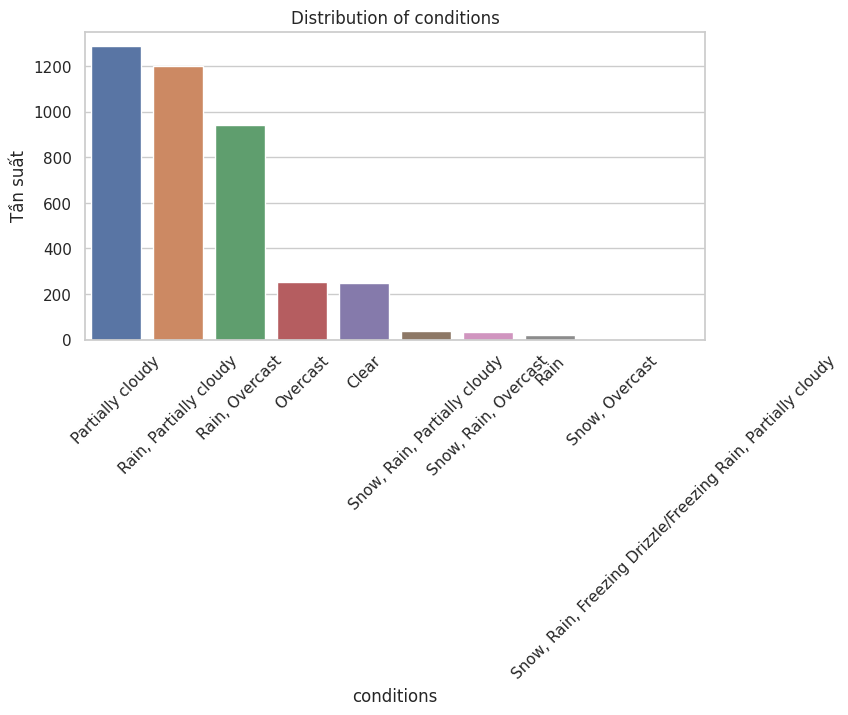


 Frequency của cột description:
 description
Partly cloudy throughout the day.                                                     1185
Cloudy skies throughout the day with rain.                                             362
Partly cloudy throughout the day with rain.                                            331
Cloudy skies throughout the day with a chance of rain throughout the day.              265
Cloudy skies throughout the day.                                                       251
Clear conditions throughout the day.                                                   245
Partly cloudy throughout the day with a chance of rain throughout the day.             159
Partly cloudy throughout the day with morning rain.                                    156
Partly cloudy throughout the day with late afternoon rain.                             140
Partly cloudy throughout the day with early morning rain.                              120
Partly cloudy throughout the day with rain c

<ipython-input-10-cf63ad6d0983>:78: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


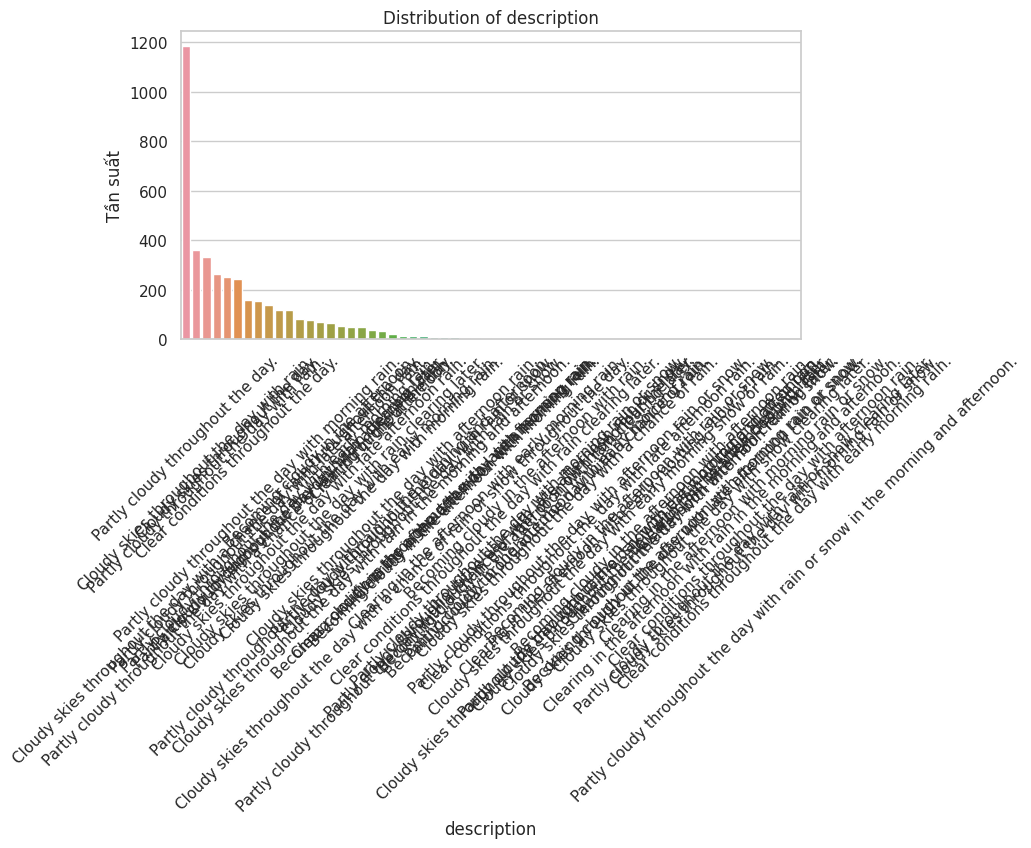


 Frequency của cột icon:
 icon
rain                 2203
partly-cloudy-day    1287
cloudy                250
clear-day             247
snow                   30
fog                     1
Name: count, dtype: int64


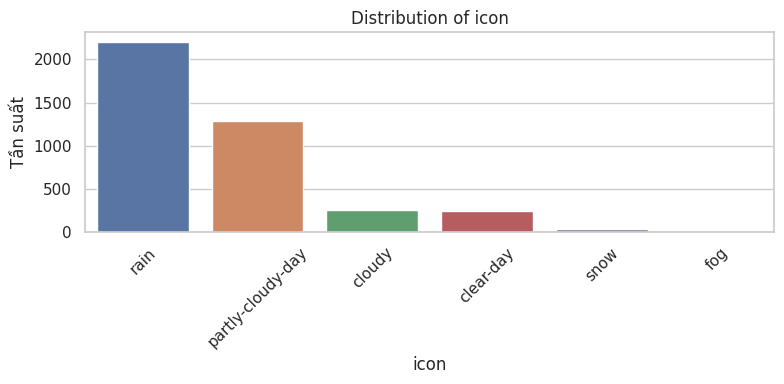


 Frequency của cột stations:
 stations
07149099999,07156099999,07146099999,07157099999,07147099999,07150099999                                                 1038
07149099999,07156099999,07146099999,07157099999,07147099999,C1292,07150099999                                            689
07149099999,07156099999,07146099999,07157099999,C1292,07147099999,07150099999                                            351
07149099999,07156099999,07146099999,E3042,07157099999,07147099999,07150099999                                            245
07149099999,07156099999,07146099999,07145099999,07157099999,07147099999,07150099999                                      211
                                                                                                                        ... 
07149099999,07156099999,07146099999,LFPV,07145099999,07157099999,07147099999,07150099999,D3623                             1
07149099999,07156099999,07146099999,LFPV,07145099999,07153099999,C2275,07157099999,07

<ipython-input-10-cf63ad6d0983>:78: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


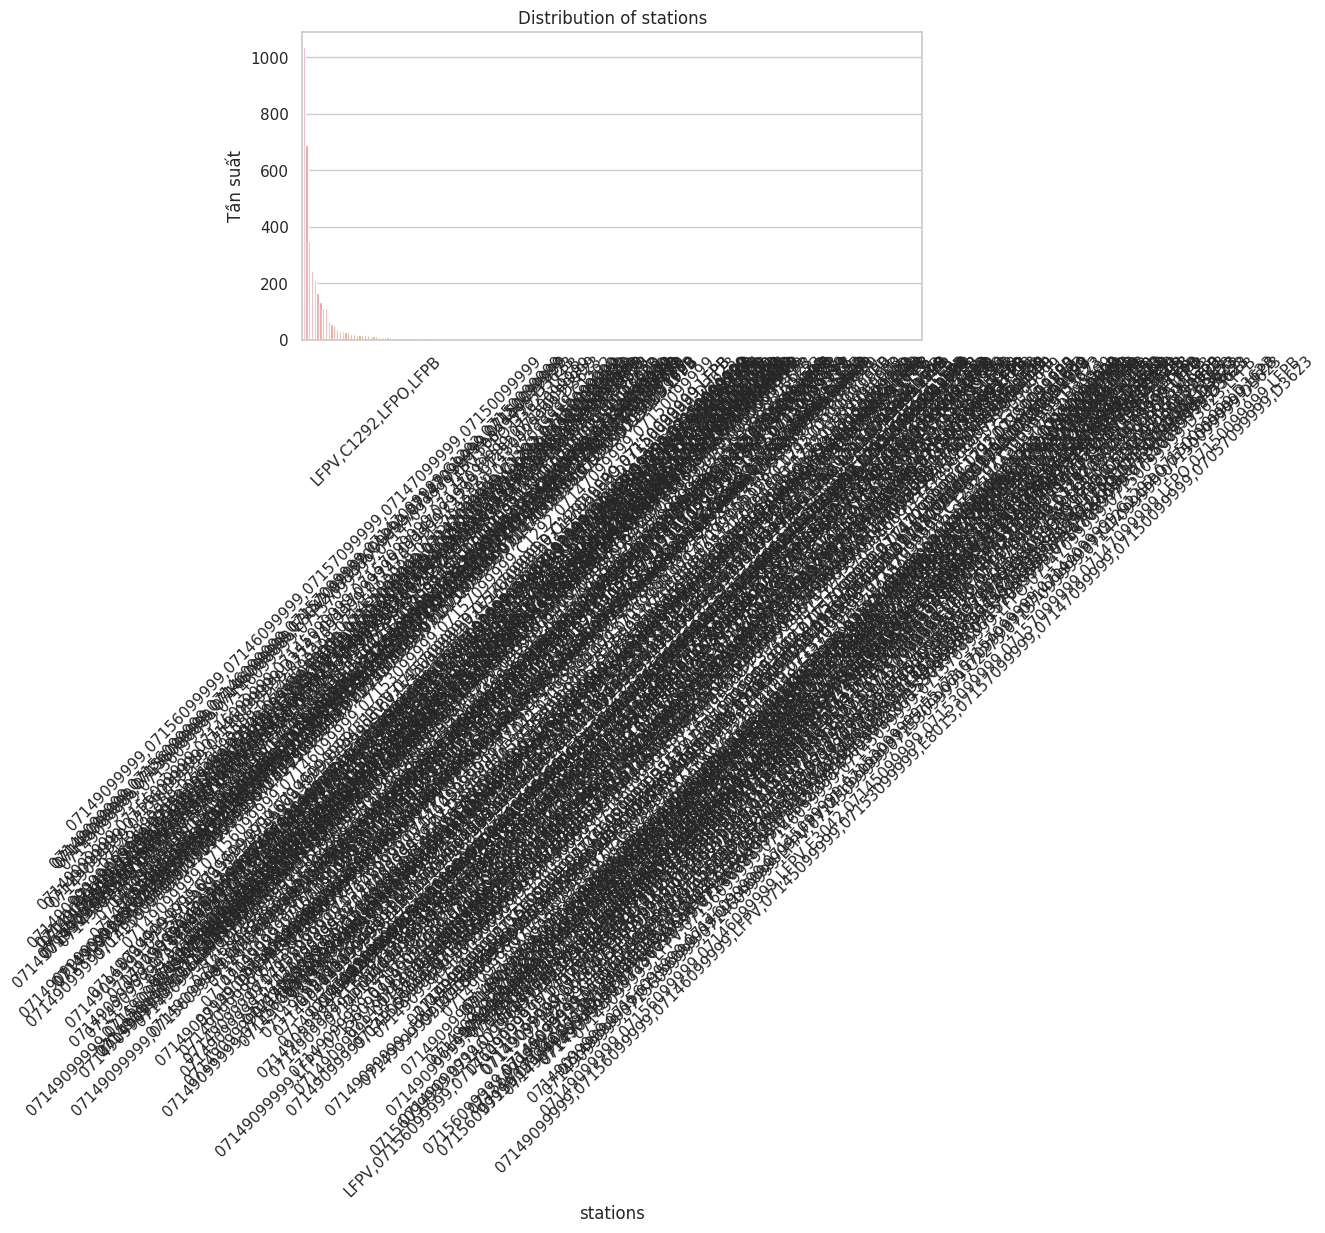

In [ ]:
plot_categorical_distributions(df, categorical_cols)

# 3. Data Preprocessing and Feature Engineering

## 3.1. Fuctions

In [ ]:
def fill_missing_preciptype(df):
    """Fill missing values in 'preciptype' column with the most frequent value."""
    if 'preciptype' in df.columns:
        df = df.copy()
        df['preciptype'] = df['preciptype'].fillna(df['preciptype'].mode()[0])
    return df

def normalize_numerical_columns(df):
    """Normalize numerical columns using Min-Max scaling."""
    numerical_cols = df.select_dtypes(include=['number']).columns
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

def clean_string_columns(df):
    """Convert string columns to lowercase and strip whitespace."""
    string_cols = df.select_dtypes(include=['object']).columns
    for col in string_cols:
        df[col] = df[col].str.lower().str.strip()
    return df

def normalize_categorical_columns(df):
    """Convert categorical data to lowercase."""
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col] = df[col].astype(str).str.lower()
    return df

def standardize_datetime(df):
    """Standardize datetime column if present."""
    if 'datetime' in df.columns:
        df['datetime'] = pd.to_datetime(df['datetime'])
    return df

def remove_outliers_iqr(df):
    """Remove outliers using the Interquartile Range (IQR) method."""
    numerical_cols = df.select_dtypes(include=['number']).columns
    Q1 = df[numerical_cols].quantile(0.25)
    Q3 = df[numerical_cols].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df

def label_encode_categorical_columns(df):
    """Apply Label Encoding to categorical columns."""
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])
    return df

In [ ]:
def create_lag_features(data, columns, lag):
    for col in columns:
        for i in range(1, lag + 1):
            data[f"{col}_lag_{i}"] = data[col].shift(i).bfill()
    return data

def create_rolling_features(data, columns, window):
    for col in columns:
        data[f"{col}_rolling_mean_{window}"] = data[col].shift(1).rolling(window=window).mean()
        data[f"{col}_rolling_std_{window}"] = data[col].shift(1).rolling(window=window).std()
    # Find the null values in rolling mean and rolling std columns
    rolling_cols = [col for col in data.columns if "rolling_mean" in col or "rolling_std" in col]
    # Fill NaN with the average value of each column
    data[rolling_cols] = data[rolling_cols].fillna(data[rolling_cols].mean())

    return data


## 3.2. Data Preprocessing and Feature Transformation

In [ ]:
# Remove Cols
df.drop(columns=['name','severerisk', 'stations'], inplace=True)

In [ ]:
print(len(df.columns))

29


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4018 entries, 2014-01-01 to 2024-12-31
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempmax           4018 non-null   float64
 1   tempmin           4018 non-null   float64
 2   temp              4018 non-null   float64
 3   feelslikemax      4018 non-null   float64
 4   feelslikemin      4018 non-null   float64
 5   feelslike         4018 non-null   float64
 6   dew               4018 non-null   float64
 7   humidity          4018 non-null   float64
 8   precip            4018 non-null   float64
 9   precipprob        4018 non-null   float64
 10  precipcover       4018 non-null   float64
 11  preciptype        2270 non-null   object 
 12  snow              4018 non-null   float64
 13  snowdepth         4018 non-null   float64
 14  windgust          4018 non-null   float64
 15  windspeed         4018 non-null   float64
 16  winddir           4018 n

In [ ]:
def preprocess_dataframe(df):
    df = fill_missing_preciptype(df)
    df = normalize_numerical_columns(df)
    df = clean_string_columns(df)
    df = standardize_datetime(df)
    df = normalize_categorical_columns(df)
    df = label_encode_categorical_columns(df)
    df = remove_outliers_iqr(df)
    return df

In [ ]:
df['sunrise'] = pd.to_datetime(df['sunrise'])
df['sunset'] = pd.to_datetime(df['sunset'])

In [ ]:
df = df.sort_index()  # Ensure the index is sorted

# Determine the split point
split_date = df.index[int(len(df) * 0.8)]  # 80% of the data

# Split the dataset
train = df[df.index < split_date]
test = df[df.index >= split_date]

# Check the sizes
print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 3214, Test size: 804


In [ ]:
train = preprocess_dataframe(train)
test = preprocess_dataframe(test)
print("Train Cols: ", train.columns )
print("Test Cols: ", test.columns )

Train Cols:  Index(['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'sunrise', 'sunset', 'moonphase',
       'conditions', 'description', 'icon'],
      dtype='object')
Test Cols:  Index(['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'sunrise', 'sunset', 'moonphase',
       'conditions', 'description', 'icon'],
      dtype='object')


In [ ]:
# Ensure datetime index
train_data = train.copy()
train_data["year"] = train.index.year
train_data["month"] = train.index.month
train_data["day"] = train.index.day
#train_data["weekday"] = train.index.weekday
train_data["week_of_year"] = train.index.isocalendar().week
train_data["day_of_year"] = train.index.dayofyear

In [ ]:
remove_cols = train_data.columns

In [ ]:
def get_numerical_columns(df):
    """Trả về danh sách các cột số trong DataFrame."""
    return df.select_dtypes(include=['number']).columns.tolist()

# Xác định các cột số
numerical_col = get_numerical_columns(train_data)

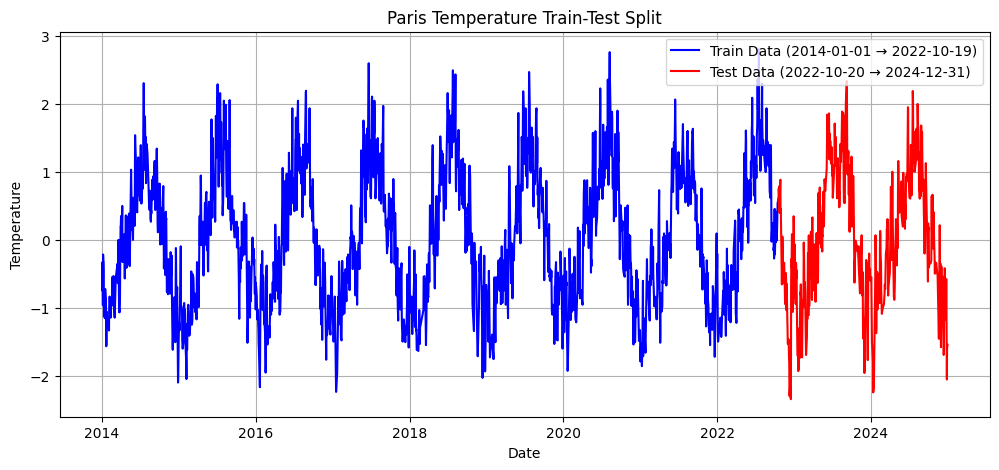

In [ ]:
# Plot train & test split
plt.figure(figsize=(12, 5))
plt.plot(train["temp"], label=f"Train Data ({train.index.min().date()} → {train.index.max().date()})", color="blue")
plt.plot(test["temp"], label=f"Test Data ({test.index.min().date()} → {test.index.max().date()})", color="red")
plt.legend()
plt.title("Paris Temperature Train-Test Split")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.grid(True)
plt.show()

In [ ]:
train_data = create_lag_features(train_data, lag=7, columns=numerical_col)
train_data = create_rolling_features(train_data, window=7, columns=["temp"])
train_data = create_rolling_features(train_data, window=14, columns=["temp"])
train_data = create_rolling_features(train_data, window=30, columns=["temp"])

<ipython-input-9-4232579de547>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{col}_lag_{i}"] = data[col].shift(i).bfill()
<ipython-input-9-4232579de547>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{col}_lag_{i}"] = data[col].shift(i).bfill()
<ipython-input-9-4232579de547>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-frag

In [ ]:
y_train = train_data["temp"]
X_train = train_data

In [ ]:
test_data = test.copy()
numerical_col = test_data.select_dtypes(include=["int64", "float64"]).columns.tolist()
test_data = create_lag_features(test_data, lag=7, columns=numerical_col)
test_data = create_rolling_features(test_data, window=7, columns=["temp"])
test_data = create_rolling_features(test_data, window=14, columns=["temp"])
test_data = create_rolling_features(test_data, window=30, columns=["temp"])

<ipython-input-9-4232579de547>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{col}_lag_{i}"] = data[col].shift(i).bfill()
<ipython-input-9-4232579de547>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{col}_lag_{i}"] = data[col].shift(i).bfill()
<ipython-input-9-4232579de547>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-frag

In [ ]:
y_test = test_data["temp"]
X_test = test_data

In [ ]:
X_test = X_test.drop(columns=[col for col in remove_cols if col in X_test.columns])
X_train = X_train.drop(columns=[col for col in remove_cols if col in X_train.columns])

## 3.3. Feature Selection

In [ ]:
import lightgbm as lgb

# Create a LightGBM dataset
lgb_train = lgb.Dataset(X_train, label=y_train)

# Train a LightGBM model
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "num_leaves": 31,
    "max_depth": -1,
    "verbose": -1
}
lgb_model = lgb.train(params, lgb_train, num_boost_round=100)

In [ ]:
# Extract feature importance
feature_importance = lgb_model.feature_importance(importance_type="gain")
feature_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

# Display the top features
print(feature_importance_df.head(10))

                    Feature   Importance
14               temp_lag_1  4628.891498
224     temp_rolling_mean_7  2773.786415
0             tempmax_lag_1  1318.722697
225      temp_rolling_std_7    82.361183
112           winddir_lag_1    57.253982
21       feelslikemax_lag_1    54.142140
119  sealevelpressure_lag_1    49.452007
105         windspeed_lag_1    43.589428
98           windgust_lag_1    36.644338
35          feelslike_lag_1    23.717565


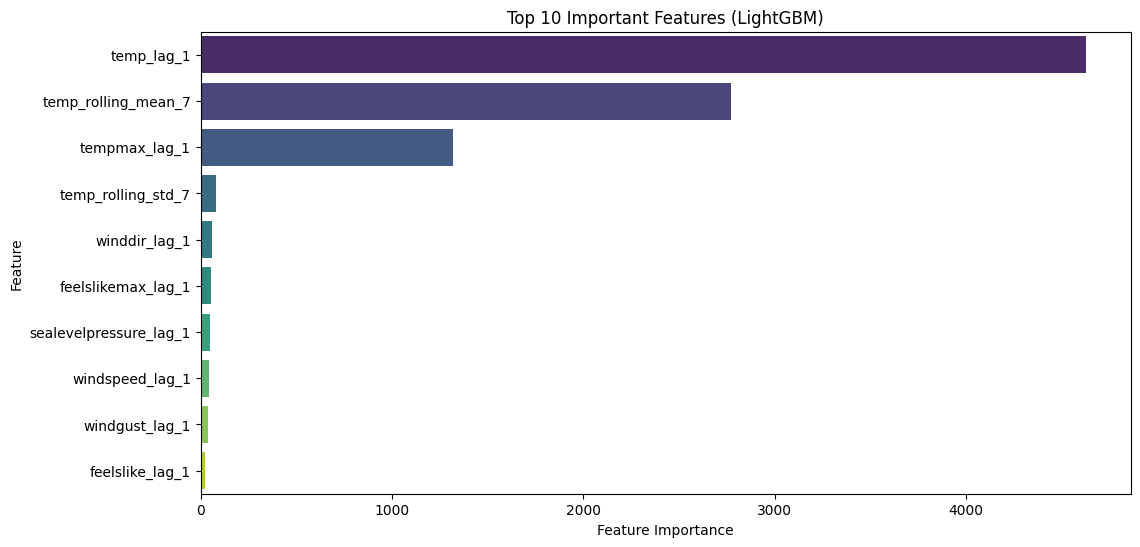

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="viridis")
plt.title("Top 10 Important Features (LightGBM)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

# 4. Modeling

## 4.1. Create LongNetTransformer

In [ ]:
pip install longnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 kB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.2/71.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.8/917.8 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.6/241.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

## 4.2. Modeling

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


Training with parameters: {'depth': 3, 'dilation_rate': 2, 'dim': 512, 'heads': 4, 'segment_size': 32}
Epoch 1/30, Loss: 1.3940498961342707
Epoch 2/30, Loss: 1.3806806537840102
Epoch 3/30, Loss: 1.3828414148754544
Epoch 4/30, Loss: 1.344012008772956
Epoch 5/30, Loss: 1.3514630926979914
Epoch 6/30, Loss: 1.3516469531589084
Epoch 7/30, Loss: 1.3817335102293227
Epoch 8/30, Loss: 1.3853751553429499
Epoch 9/30, Loss: 1.3436832427978516
Epoch 10/30, Loss: 1.3730073504977756
Epoch 11/30, Loss: 1.3458502954906888
Epoch 12/30, Loss: 1.3607007530000474
Epoch 13/30, Loss: 1.3847497834099665
Epoch 14/30, Loss: 1.372121148639255
Epoch 15/30, Loss: 1.3500238127178616
Epoch 16/30, Loss: 1.3710960282219782
Epoch 17/30, Loss: 1.3333151075575087
Epoch 18/30, Loss: 1.3833631939358182
Epoch 19/30, Loss: 1.367041442129347
Epoch 20/30, Loss: 1.363697025511
Epoch 21/30, Loss: 1.3552438815434773
Epoch 22/30, Loss: 1.331361518965827
Epoch 23/30, Loss: 1.380675819185045
Epoch 24/30, Loss: 1.3427578608194988
Epo

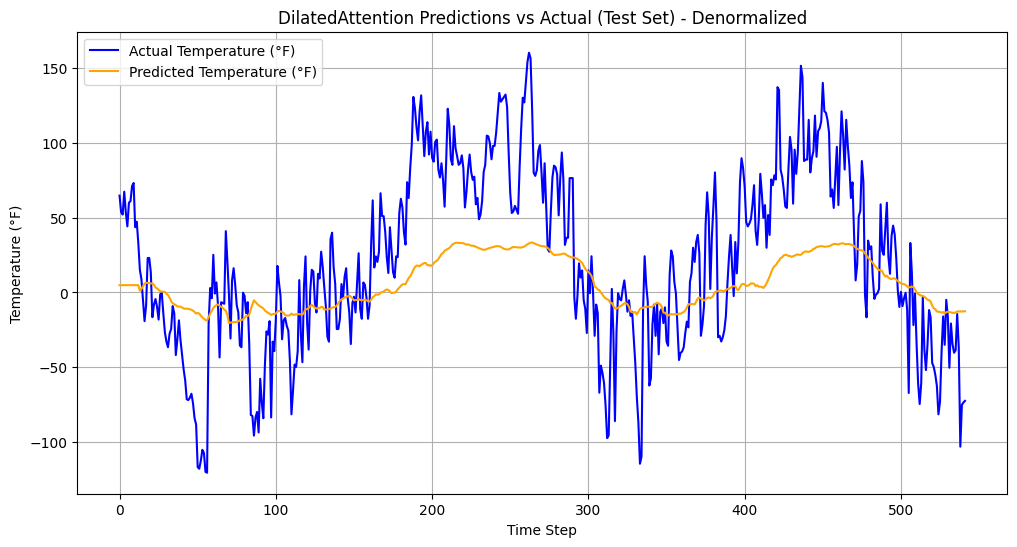

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from long_net import DilatedAttention
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
import torch.nn.functional as F

# Định nghĩa device (CPU hoặc GPU trên Kaggle)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chuyển đổi dữ liệu thành số
X_train_numeric = X_train.astype(float)
X_test_numeric = X_test.astype(float)
y_train_numeric = y_train.astype(float)
y_test_numeric = y_test.astype(float)

# Đảm bảo X_train và X_test có cùng số cột (lấy số cột nhỏ nhất)
min_features = min(X_train_numeric.shape[1], X_test_numeric.shape[1])  # 195
X_train_numeric = X_train_numeric.iloc[:, :min_features]
X_test_numeric = X_test_numeric.iloc[:, :min_features]

# Chuyển đổi thành Tensor
X_train_tensor = torch.tensor(X_train_numeric.to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_numeric.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_numeric.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_numeric.to_numpy(), dtype=torch.float32)

# Reshape dữ liệu thành (samples, sequence_length, input_dim)
sequence_length = 195  
input_dim = X_train_tensor.shape[1] // sequence_length  
num_samples_train = X_train_tensor.shape[0]
num_samples_test = X_test_tensor.shape[0]

if X_train_tensor.shape[1] % sequence_length == 0:
    X_train_tensor = X_train_tensor.view(num_samples_train, sequence_length, input_dim)
    X_test_tensor = X_test_tensor.view(num_samples_test, sequence_length, input_dim)
else:
    raise ValueError(f"Cannot reshape X_train with {X_train_tensor.shape[1]} features into sequence_length={sequence_length}")

# Tạo Dataset và DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Định nghĩa hàm mất mát tùy chỉnh (dùng PyTorch)
def custom_loss(y_true, y_pred):
    # Mean Squared Error (MSE) cơ bản
    mse = torch.mean((y_true - y_pred) ** 2)

    # Thành phần khuyến khích biên độ dao động
    amplitude_loss = torch.mean(
        torch.abs(torch.max(y_true) - torch.max(y_pred)) +
        torch.abs(torch.min(y_true) - torch.min(y_pred))
    )

    # Kết hợp MSE và amplitude loss
    return mse + 0.1 * amplitude_loss

# Định nghĩa mô hình tùy chỉnh với DilatedAttention
class TimeSeriesLongNet(nn.Module):
    def __init__(self, input_dim, dim, depth, heads, dilation_rate, segment_size):
        super(TimeSeriesLongNet, self).__init__()
        self.input_projection = nn.Linear(input_dim, dim)
        self.attn_layers = nn.ModuleList([
            DilatedAttention(dim=dim, heads=heads, dilation_rate=dilation_rate, segment_size=segment_size)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(dim)
        self.output_projection = nn.Linear(dim, 1)

    def forward(self, x):
        x = self.input_projection(x)  # (batch_size, seq_len, dim)
        for attn in self.attn_layers:
            attn_output = attn(x)
            if attn_output.shape[1] != x.shape[1]:
                pad_length = x.shape[1] - attn_output.shape[1]
                if pad_length > 0:
                    attn_output = nn.functional.pad(attn_output, (0, 0, 0, pad_length))
                elif pad_length < 0:
                    attn_output = attn_output[:, :x.shape[1], :]
            x = attn_output + x  # Residual connection
            x = self.norm(x)
        x = self.output_projection(x[:, -1, :])  # Lấy giá trị cuối cùng
        return x

# Hàm tính MASE (Mean Absolute Scaled Error)
def mase(y_true, y_pred, y_train, seasonality=1):
    scale = np.mean(np.abs(np.diff(y_train)))
    return np.mean(np.abs(y_true - y_pred)) / scale

# Grid Search Hyperparameter Tuning
param_grid = {
    'dim': [512],
    'depth': [3, 6],
    'heads': [4, 8],
    'dilation_rate': [2,4],
    'segment_size': [32, 64]
}

best_mase = float('inf')
best_params = None

# Grid Search
for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")

    # Khởi tạo mô hình và chuyển sang GPU/CPU
    model = TimeSeriesLongNet(
        input_dim=input_dim,  # 3
        dim=params['dim'],
        depth=params['depth'],
        heads=params['heads'],
        dilation_rate=params['dilation_rate'],
        segment_size=params['segment_size']
    )
    model.to(device)  # Chuyển mô hình sang device (GPU hoặc CPU)

    # Huấn luyện mô hình
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 30
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = custom_loss(y_batch.unsqueeze(-1), output)  # Sử dụng custom_loss
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_train_loss/len(train_loader)}")

    # Dự đoán và tính MASE trên tập kiểm tra
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            pred = model(x_batch)
            predictions.extend(pred.cpu().numpy().flatten())
            actuals.extend(y_batch.numpy().flatten())

    # Tính MASE
    mase_value = mase(np.array(actuals), np.array(predictions), y_train_numeric.to_numpy())

    print(f"MASE: {mase_value}")

    # Lưu lại mô hình tốt nhất
    if mase_value < best_mase:
        best_mase = mase_value
        best_params = params

print(f"Best Hyperparameters: {best_params}, MASE: {best_mase}")

# Vẽ biểu đồ dự đoán 
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        pred = model(x_batch)
        predictions.extend(pred.cpu().numpy().flatten())
        actuals.extend(y_batch.numpy().flatten())

# Giải chuẩn hóa 
min_temp = 20
max_temp = 80

def denormalize(data, min_val, max_val):
    return data * (max_val - min_val) + min_val

actuals_denorm = denormalize(np.array(actuals), min_temp, max_temp)
predictions_denorm = denormalize(np.array(predictions), min_temp, max_temp)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(actuals_denorm, label="Actual Temperature (°F)", color='blue')
plt.plot(predictions_denorm, label="Predicted Temperature (°F)", color='orange')
plt.title("DilatedAttention Predictions vs Actual (Test Set) - Denormalized")
plt.xlabel("Time Step")
plt.ylabel("Temperature (°F)")
plt.legend()
plt.grid(True)
plt.show()

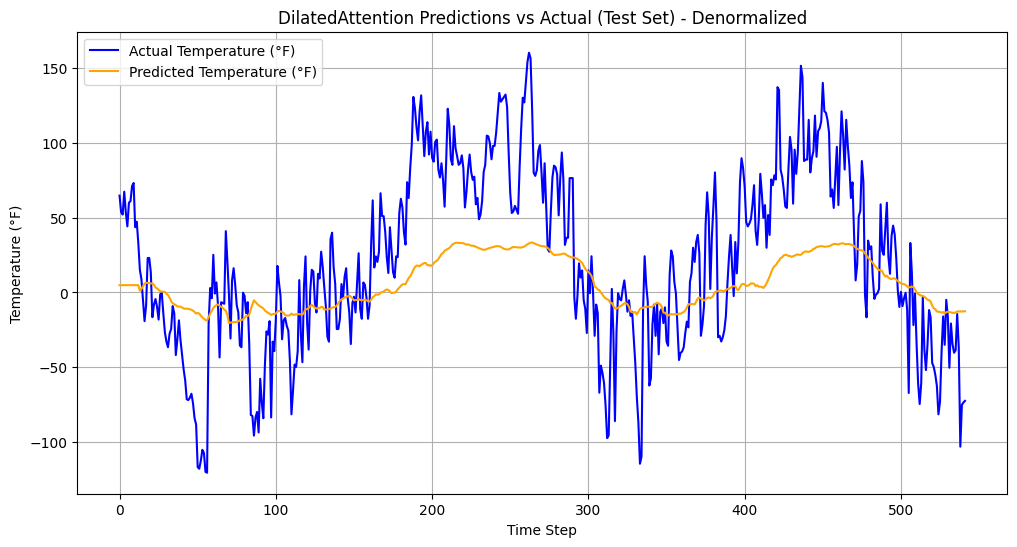

In [ ]:
actuals_denorm = denormalize(np.array(actuals), min_temp, max_temp)
predictions_denorm = denormalize(np.array(predictions), min_temp, max_temp)
# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(actuals_denorm, label="Actual Temperature (°F)", color='blue')
plt.plot(predictions_denorm, label="Predicted Temperature (°F)", color='orange')
plt.title("DilatedAttention Predictions vs Actual (Test Set) - Denormalized")
plt.xlabel("Time Step")
plt.ylabel("Temperature (°F)")
plt.legend()
plt.grid(True)
plt.show()